In [47]:
import pandas as pd
import numpy as np

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys

In [48]:
ravdess_path = 'C:/Users/shiva/Desktop/Python/Machine Learning/speech recognition/ravdess/'

ravdess_directory_list = os.listdir(ravdess_path)

fileEmotion = []
filePath = []

for dir in ravdess_directory_list:
    actor = os.listdir(ravdess_path + dir+'/')
    for file in actor:
        name = file.split('.')[0]
        name = name.split('-')
        
        fileEmotion.append(int(name[2]))
        filePath.append(ravdess_path + dir + '/' + file)

In [49]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(fileEmotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(filePath, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust', 8:'Surprise'}, inplace=True)    

Ravdess_df.to_csv("Ravdess_df.csv",index=False)


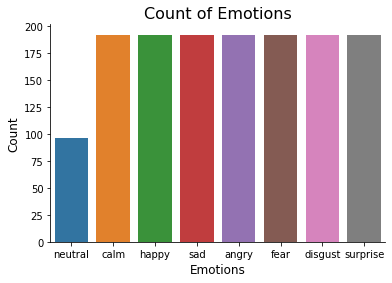

In [50]:
plt.title('Count of Emotions', size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [51]:
from IPython.display import Audio

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()


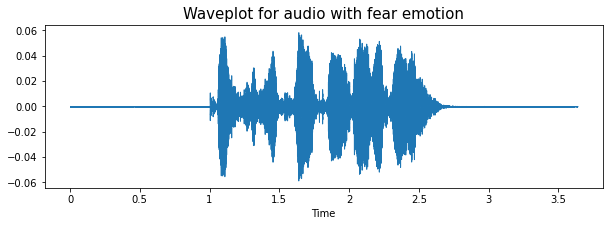

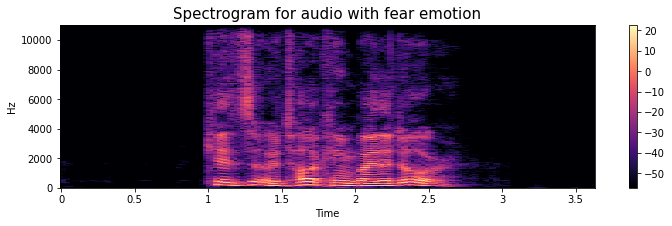

In [52]:

emotion='fear'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

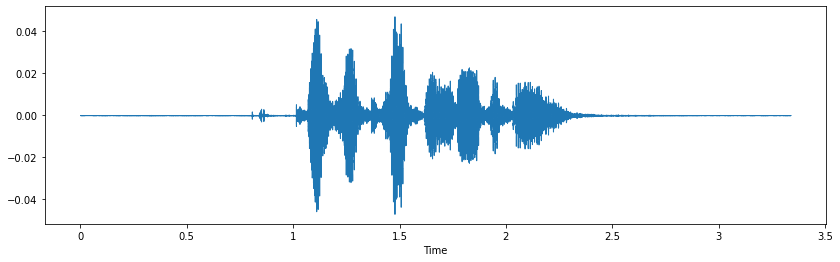

In [53]:
#Data augmentation

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

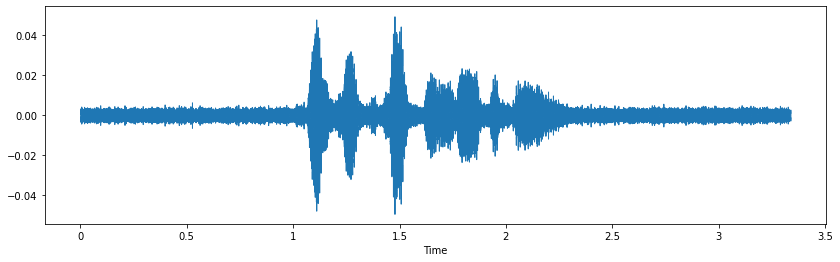

In [54]:
#noise injection
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate) 


In [55]:
#ZCR can be interpreted as a measure of the noisiness of a signal.
def extract_features(data):
    #zero srossing rate
    features  = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    features = np.hstack((features,zcr))
    
    #chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    features = np.hstack((chroma_stft,zcr))
    
    #mfcc
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    features = np.hstack((chroma_stft,zcr))
    
    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    features = np.hstack((rms,zcr))
    
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    features = np.hstack((mel,zcr))
    
    return features

In [56]:
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    #data with shift
    shift_data = shift(data)
    res4 = extract_features(shift_data)
    result = np.vstack((result,res4))
    
    return result

In [57]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        
        Y.append(emotion)

len(X), len(Y), Ravdess_df.Path.shape 
# feature = get_features(Ravdess_df.Path[0])

(5760, 5760, (1440,))

In [58]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

In [59]:
# As this is a multiclass classification problem onehotencoding our Y.
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray() 

In [60]:
import pickle
with open("encoder", "wb") as f: 
    pickle.dump(encoder, f)

In [61]:
from joblib import dump, load
dump(encoder, 'encoder.joblib') 

['encoder.joblib']

In [62]:
# splitting data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [63]:
x_train.shape

AttributeError: 'list' object has no attribute 'shape'

In [64]:
    
# scaling our data with sklearn's Standard scaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape 

((4320, 129), (4320, 8), (1440, 129), (1440, 8))

In [65]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape 

((4320, 129, 1), (4320, 8), (1440, 129, 1), (1440, 8))

In [66]:
# from keras.applications import resnet
# from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, AveragePooling2D, Input
# incept_model = resnet.ResNet50(include_top=False, weights ="imagenet", input_tensor=Input(shape=()))

In [67]:
# incept_model.summary()

In [68]:
# resnetModel = incept_model.output
# resnetModel = AveragePooling2D(pool_size=(7, 7))(resnetModel)
# resnetModel = Flatten(name="flatten")(resnetModel)
# resnetModel = Dense(256, activation="relu")(resnetModel)
# resnetModel = Dropout(0.5)(resnetModel)
# resnetModel = Dense(8, activation="softmax")(resnetModel)

In [69]:

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))


model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()    
    
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4,verbose=0,patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=500, validation_data=(x_test, y_test), callbacks=[rlrp])
   

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 129, 256)          1536      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 65, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 65, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 33, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 33, 128)           163968    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 17, 128)         

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 129, 256)          1536      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 65, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 65, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 33, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 33, 128)           163968    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 17, 128)         

In [71]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at c:\Users\shiva\Desktop\Python\Machine Learning\speech recognition\saved_models\Emotion_Voice_Detection_Model.h5 


In [72]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

45/45 [==============================] - 2s 15ms/step - loss: 0.8526 - accuracy: 0.7118
Accuracy of our model on test data :  71.18055820465088 %


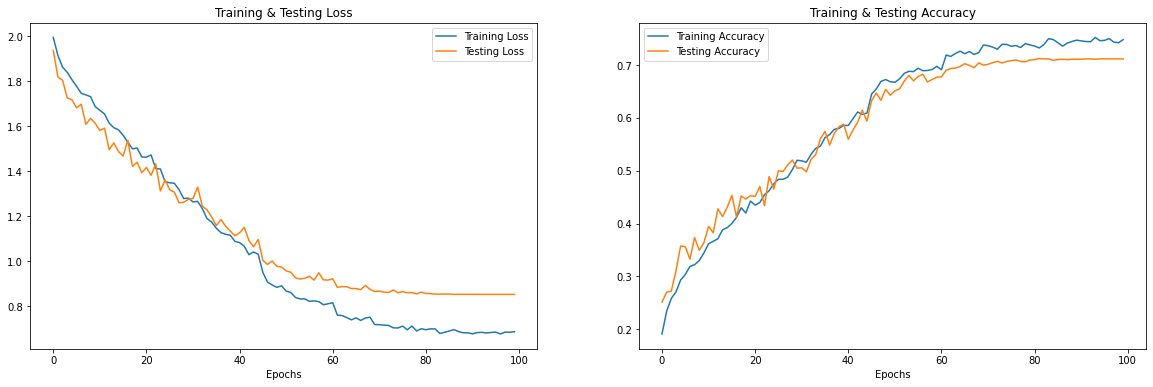

In [73]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [74]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)


In [82]:
pred_test.shape

(1440, 8)

In [76]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry      surprise
1              sad           sad
2          disgust       disgust
3            angry         angry
4            happy         happy
5            happy         angry
6              sad         happy
7            angry         angry
8            happy         happy
9             calm          calm

In [95]:
features = get_features("static/file.wav")
T=[]
for ele in features:
    T.append(ele)
    
Input = pd.DataFrame(T)    
scaler = StandardScaler()
Input = scaler.fit_transform(Input)
Input = np.expand_dims(Input, axis=2)
    
Output = model.predict(Input)
answer=Output.argmax(axis=1)
encoder1 = load('encoder.joblib')
final =encoder1.inverse_transform(Output)


In [105]:
print(answer)
print(final)

[4 0 1 4]
[['happy']
 ['angry']
 ['calm']
 ['happy']]


In [1]:
Output.shape


NameError: name 'Output' is not defined

In [106]:
print(final)

[['happy']
 ['angry']
 ['calm']
 ['happy']]
